In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
from scipy import stats

from src.utils import runge_kutta, lorentz_ode, mae, mse
from src.wishart import Wishart

from sklearn.cluster import DBSCAN

In [30]:
xs = np.load("../data/bitcoin_ts.npy")

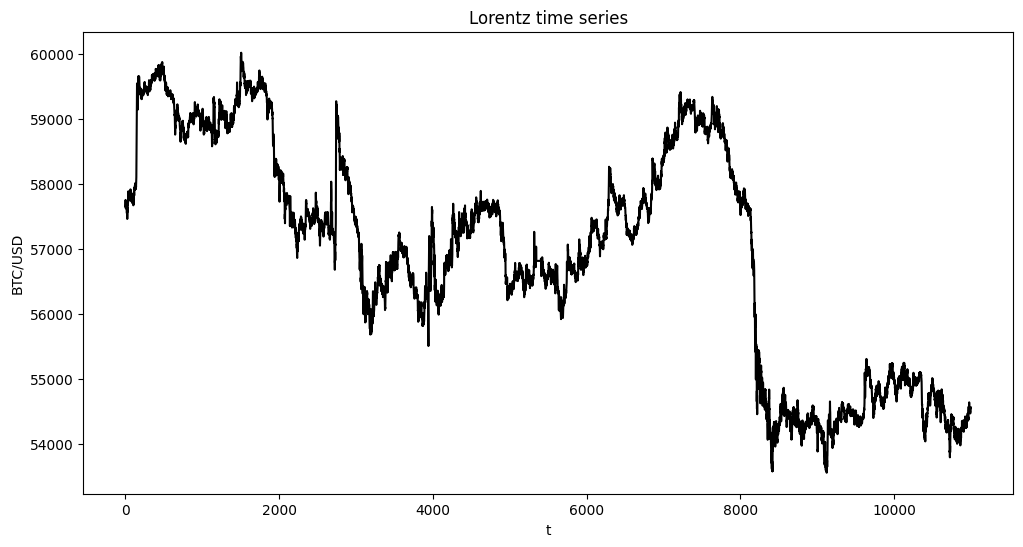

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.title("Lorentz time series")
plt.plot(xs, c='black')
plt.xlabel("t")
plt.ylabel("BTC/USD")
plt.savefig("BTC_ts")
plt.show()

In [32]:
ts_min = min(xs)
ts_max = max(xs)

xs = (xs - ts_min) / (ts_max - ts_min)

In [33]:
from predictive_clustering import PredictiveClustering

#entropy approach
pc = PredictiveClustering(10, 4, choose_prediction='dbscan_mode', classify_point='entropy', entropy_max=2., eps=0.01)

In [34]:
x_train, x_test = xs[:10000], xs[10000:]
x_train.shape, x_test.shape

((10000,), (1000,))

In [35]:
pc.generate_motives(x_train)

In [36]:
y_pred_matrix = []
y_true_matrix = []

horizon = 50

for i in range(50):
    y_pred_matrix.append(pc.predict(x_train, horizon))
    y_true_matrix.append(x_test[:horizon])

    x_train = np.append(x_train, x_test[0])
    x_test = x_test[1:]

In [37]:
y_true_matrix = np.array(y_true_matrix)
y_pred_matrix = np.array(y_pred_matrix)

In [38]:
y_true_matrix = y_true_matrix * (ts_max - ts_min) + ts_min
y_pred_matrix = y_pred_matrix * (ts_max - ts_min) + ts_min

In [39]:
np.save(f"../data/y_pred_bitcoin.npy", y_pred_matrix)
np.save(f"../data/y_true_bitcoin.npy", y_true_matrix)

In [40]:
y_true = np.load("../data/y_true_bitcoin.npy")
y_pred = np.load("../data/y_pred_bitcoin.npy")

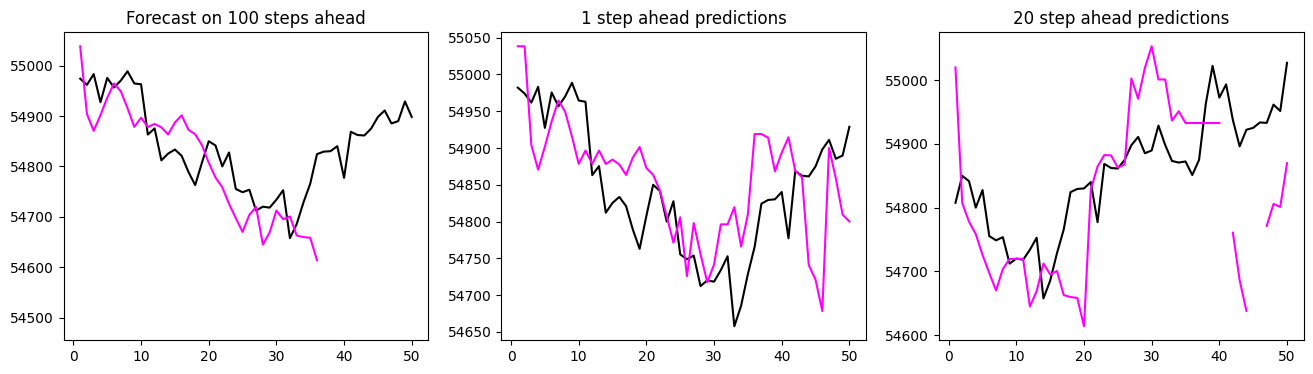

In [41]:
fig, axs = plt.subplots(1,3,figsize=(16,4))

axs[0].set_title("Forecast on 100 steps ahead")
axs[0].plot(np.arange(1, 51), y_true[1], c='black')
axs[0].plot(np.arange(1, 51), y_pred[1], c='magenta')


axs[1].set_title("1 step ahead predictions")
axs[1].plot(np.arange(1, 51), y_true[:, 0], c='black')
axs[1].plot(np.arange(1, 51), y_pred[:, 0], c='magenta')

axs[2].set_title("20 step ahead predictions")
axs[2].plot(np.arange(1, 51), y_true[:, 19], c='black')
axs[2].plot(np.arange(1, 51), y_pred[:, 19], c='magenta')

plt.savefig("bitcoin_predictions")

In [42]:
maes = []
pct_nonpred = []
for i in range(50):
    maes.append(mae(y_true[:,i], y_pred[:,i]))
    pct_nonpred.append(np.isnan(y_pred[:,i]).sum() / len(y_pred[:,i]))

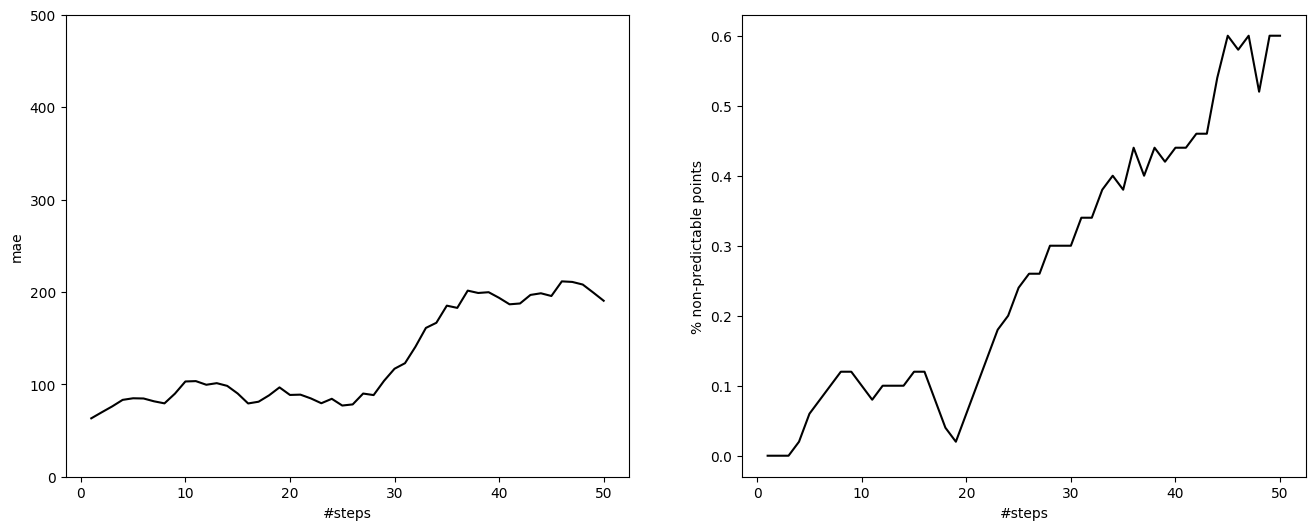

In [43]:
fig, axs = plt.subplots(1,2,figsize=(16,6))

axs[0].plot(range(1,51), maes, c='black')
axs[0].set_ylabel('mae')
axs[0].set_xlabel('#steps')
axs[0].set_ylim(0, 500)

axs[1].plot(range(1,51), pct_nonpred, c='black')
axs[1].set_ylabel('% non-predictable points')
axs[1].set_xlabel('#steps')

plt.savefig("bitcoin_res")